In [2]:
import zipfile
zipped = zipfile.ZipFile('/content/fma_metadata.zip', 'r')
zipped.extractall('/content')
zipped.close()

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout
import numpy as np
import os
import IPython.display as ipd
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn
import pandas as pd
import sklearn.preprocessing, sklearn.decomposition, sklearn.svm
from sklearn.model_selection import train_test_split
import sklearn.ensemble
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

In [36]:
#@title Importing data
tracks = pd.read_csv('/content/fma_metadata/tracks.csv',index_col=0,header=[0,1])
features = pd.read_csv('/content/fma_metadata/features.csv',index_col=0,header=[0,1,2])
echonest = pd.read_csv('/content/fma_metadata/echonest.csv')
genres = pd.read_csv('/content/fma_metadata/genres.csv')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning:

Columns (0,1,2,3,4,5,6,7,8,11,13,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249) have mixed types.Spec

In [37]:
ipd.display(tracks['track'].head())
#ipd.display(tracks['album'].head())
#ipd.display(tracks['artist'].head())
#ipd.display(tracks['set'].head())

,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,genres_all,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
track_id,,,,,,,,,,,,,,,,,,,,
2,256000,0,NaN,2008-11-26 01:48:12,2008-11-26 00:00:00,168,2,Hip-Hop,[21],[21],NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
3,256000,0,NaN,2008-11-26 01:48:14,2008-11-26 00:00:00,237,1,Hip-Hop,[21],[21],NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
5,256000,0,NaN,2008-11-26 01:48:20,2008-11-26 00:00:00,206,6,Hip-Hop,[21],[21],NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
10,192000,0,Kurt Vile,2008-11-25 17:49:06,2008-11-26 00:00:00,161,178,Pop,[10],[10],NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
20,256000,0,NaN,2008-11-26 01:48:56,2008-01-01 00:00:00,311,0,NaN,"[76, 103]","[17, 10, 76, 103]",NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


In [38]:
columns = ['mfcc', 'chroma_cens', 'tonnetz', 'spectral_contrast','spectral_rolloff','zcr','rmse']
ipd.display(features[columns].head().style.format('{:.2f}'))

In [39]:
features.shape

(106574, 518)

In [40]:
genres = pd.DataFrame(tracks['track']['genre_top'])
genres['genre_top'].value_counts()

Rock                   14182
Experimental           10608
Electronic              9372
Hip-Hop                 3552
Folk                    2803
Pop                     2332
Instrumental            2079
International           1389
Classical               1230
Jazz                     571
Old-Time / Historic      554
Spoken                   423
Country                  194
Soul-RnB                 175
Blues                    110
Easy Listening            24
Name: genre_top, dtype: int64

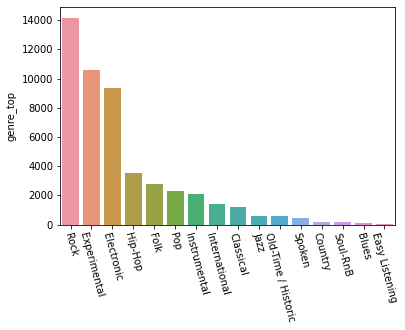

In [41]:
genre_plot = sns.barplot(x=genres['genre_top'].value_counts().index, y=genres['genre_top'].value_counts())
genre_plot.set_xticklabels(genre_plot.get_xticklabels(),rotation=-75)
plt.savefig('save_as_a_png.png')

In [42]:
#@title Data Preprocessing
combined_features = features['mfcc']
combined_features

statistics   kurtosis                                                    \
number             01        02        03        04        05        06   
track_id                                                                  
2            3.856789  1.541901  0.000816  0.330728  0.118731 -0.342687   
3            4.296755  1.399977  0.112535 -0.211170  0.032953 -0.023489   
5            2.624517  2.415293  0.440233 -0.782131 -0.771069 -0.724216   
10           5.076893  1.161854  2.095651  1.372743 -0.203574 -0.345354   
20          11.880132  4.085320  0.002655  1.518562  0.181947  0.339014   
...               ...       ...       ...       ...       ...       ...   
155316       4.895152  5.361988  3.186483  0.510951 -0.143080  0.342237   
155317       0.040857  1.752112  0.442188 -0.380960 -0.739809 -0.023362   
155318       0.581889 -0.129386  0.662489  1.025676  0.170532  1.827692   
155319       5.164501  3.716359  2.881116  3.273014  0.707058  1.951918   
155320       4.619462  1.234909  1.236056  0.335577  0.009484  1.682914   

statistics                                          ...        std             \
number            07        08        09        10  ...         11         12   
track_id                                            ...                         
2          -0.259252  0.146735  0.410656 -0.162872  ...  10.059609   8.601942   
3           0.150404  0.046454  0.033484 -0.064596  ...   8.771966  10.026867   
5           0.090260  0.152119  0.261731 -0.608905  ...   8.863638   9.581952   
10         -0.529139  0.561974  0.281350 -0.150672  ...   8.289734   7.985110   
20          0.367611  0.069932 -0.016032  0.026012  ...   7.706648   6.498904   
...              ...       ...       ...       ...  ...        ...        ...   
155316      0.771449 -0.184232  0.143237  0.009016  ...   7.401937   6.629143   
155317      0.264786  0.072084  0.295485  0.535544  ...   6.734644   6.955739   
155318     -0.189439  1.141878  0.022045  0.175235  ...   7.061307   6.943147   
155319     -0.151555  0.230036 -0.327132  1.182421  ...   7.300332   5.971618   
155320      0.317069 -0.128262  0.076033  0.112258  ...   7.538454   7.840639   

statistics                                                              \
number            13        14        15        16        17        18   
track_id                                                                 
2           9.284250  9.245516  8.520863  8.560472  7.651871  7.246555   
3           6.978541  7.650417  9.600357  7.222888  8.398293  7.285423   
5           8.895723  8.141456  8.201844  7.780963  7.132692  7.539753   
10          7.075400  6.972649  7.071393  7.270959  7.051070  6.928591   
20          6.845514  6.934421  7.019398  6.983841  6.813648  7.520811   
...              ...       ...       ...       ...       ...       ...   
155316      5.860062  6.230947  5.923375  5.586200  5.516872  5.755764   
155317      6.662989  6.478699  6.019901  5.757353  5.280114  5.674062   
155318      6.522048  6.780707  6.311563  5.789986  5.466107  5.607614   
155319      6.355647  5.602213  5.887583  5.110033  5.407447  5.317993   
155320      6.794503  6.431658  6.400701  6.733516  5.603289  5.868379   

statistics                      
number            19        20  
track_id                        
2           7.077188  7.391859  
3           7.417791  8.777440  
5           8.452527  7.334442  
10          6.430473  6.186294  
20          7.098001  7.032246  
...              ...       ...  
155316      5.105072  5.019556  
155317      5.541949  5.266131  
155318      5.685448  5.449005  
155319      5.187994  5.260817  
155320      6.128483  5.550875  

[106574 rows x 140 columns]

In [43]:
grouped_genres = genres.groupby('genre_top')
balanced_genres = pd.DataFrame(columns=['genre_top'])
genre_list = ['Rock','Experimental','Electronic','Hip-Hop','Folk','Pop','Instrumental']
#ipd.display(grouped_genres.get_group('Rock')[:2000].reset_index())
for genre in genre_list:
    balanced_genres = pd.concat([balanced_genres,grouped_genres.get_group(genre)[:2000]])

print(balanced_genres['genre_top'].value_counts())
balanced_genres

Rock            2000
Experimental    2000
Electronic      2000
Hip-Hop         2000
Folk            2000
Pop             2000
Instrumental    2000
Name: genre_top, dtype: int64


,genre_top
135,Rock
136,Rock
151,Rock
152,Rock
153,Rock
...,...
148128,Instrumental
148129,Instrumental
148130,Instrumental
148131,Instrumental


In [44]:
track_ids = balanced_genres.index.tolist()
track_features = combined_features.loc[track_ids]
track_features

statistics   kurtosis                                                    \
number             01        02        03        04        05        06   
track_id                                                                  
135          2.021638  0.269172  0.755836  0.861484  1.909718  0.382428   
136         13.691644  0.702855  2.484976  7.980183  0.209275  1.472870   
151          8.044993  1.115101  1.708385  0.482039  0.088183  0.000533   
152          7.162528 -0.251133  1.689257  0.128104 -0.853159 -0.233372   
153         14.468616  3.223378 -0.510767 -0.652397 -0.419132  0.366079   
...               ...       ...       ...       ...       ...       ...   
148128       2.910794  0.291306 -0.180089  1.240595  0.159772  0.377964   
148129      -1.321243 -0.282412 -0.376740 -0.358387  0.160722 -0.491458   
148130       2.358007  0.309532  3.033040  2.161145  1.845666  1.126647   
148131       2.110393  0.541523  2.227178  2.600832  1.442967  0.732040   
148132       1.879478  0.673871  0.641724  0.571810  0.045750  0.024153   

statistics                                          ...        std             \
number            07        08        09        10  ...         11         12   
track_id                                            ...                         
135         3.033167  0.276814  0.344835  0.095461  ...   8.329439   8.129856   
136         2.104760  0.164231  0.288295  0.212297  ...   6.960906   8.477464   
151         0.008176  0.335411 -0.134841  0.068216  ...   7.174704   6.137657   
152         0.042815  1.103065 -0.759770 -0.679819  ...   8.083424   6.650053   
153        -0.226173  0.183614  0.216913  0.083776  ...   6.114115   6.469112   
...              ...       ...       ...       ...  ...        ...        ...   
148128      0.170654  0.280512 -0.190479 -0.301314  ...   7.670261   6.612138   
148129      0.657013 -0.632479  0.207733 -0.838016  ...   8.998077   8.014416   
148130      0.816919  1.431923  0.316134  0.800893  ...   7.646496   7.649741   
148131      0.359726  1.125986  0.308315  0.814518  ...   8.084579   8.812723   
148132      0.554600  1.178810 -0.147373 -0.413808  ...  10.817488  11.037899   

statistics                                                              \
number            13        14        15        16        17        18   
track_id                                                                 
135         7.796185  6.755871  6.407472  5.984369  6.050004  5.692363   
136         8.295549  8.519705  8.484787  7.838695  7.337792  7.240948   
151         6.587673  6.327073  8.807613  7.392186  6.808066  6.320422   
152         6.340897  6.097323  6.395099  6.092227  5.699416  5.911937   
153         4.984094  5.218048  4.981048  6.233972  4.723229  6.117352   
...              ...       ...       ...       ...       ...       ...   
148128      7.184205  7.123802  7.944510  6.259186  6.326586  6.573137   
148129      7.787213  8.642241  8.096421  7.563630  7.201268  7.079261   
148130      7.928670  7.481312  7.566584  6.742290  6.521764  5.783477   
148131      8.359750  8.019738  9.175700  7.531100  6.944691  7.074626   
148132      9.242756  8.353446  9.568764  8.707694  8.460194  7.626732   

statistics                      
number            19        20  
track_id                        
135         6.055962  5.925325  
136         6.968402  6.127878  
151         6.074442  6.507479  
152         6.624181  5.551071  
153         4.750901  5.295139  
...              ...       ...  
148128      6.575711  5.943985  
148129      7.001438  6.619577  
148130      6.396101  7.019425  
148131      7.837447  7.614411  
148132      7.350070  7.881918  

[14000 rows x 140 columns]

In [45]:
data = pd.concat([track_features,balanced_genres],axis=1)
data

,"(kurtosis, 01)","(kurtosis, 02)","(kurtosis, 03)","(kurtosis, 04)","(kurtosis, 05)","(kurtosis, 06)","(kurtosis, 07)","(kurtosis, 08)","(kurtosis, 09)","(kurtosis, 10)",...,"(std, 12)","(std, 13)","(std, 14)","(std, 15)","(std, 16)","(std, 17)","(std, 18)","(std, 19)","(std, 20)",genre_top
135,2.021638,0.269172,0.755836,0.861484,1.909718,0.382428,3.033167,0.276814,0.344835,0.095461,...,8.129856,7.796185,6.755871,6.407472,5.984369,6.050004,5.692363,6.055962,5.925325,Rock
136,13.691644,0.702855,2.484976,7.980183,0.209275,1.472870,2.104760,0.164231,0.288295,0.212297,...,8.477464,8.295549,8.519705,8.484787,7.838695,7.337792,7.240948,6.968402,6.127878,Rock
151,8.044993,1.115101,1.708385,0.482039,0.088183,0.000533,0.008176,0.335411,-0.134841,0.068216,...,6.137657,6.587673,6.327073,8.807613,7.392186,6.808066,6.320422,6.074442,6.507479,Rock
152,7.162528,-0.251133,1.689257,0.128104,-0.853159,-0.233372,0.042815,1.103065,-0.759770,-0.679819,...,6.650053,6.340897,6.097323,6.395099,6.092227,5.699416,5.911937,6.624181,5.551071,Rock
153,14.468616,3.223378,-0.510767,-0.652397,-0.419132,0.366079,-0.226173,0.183614,0.216913,0.083776,...,6.469112,4.984094,5.218048,4.981048,6.233972,4.723229,6.117352,4.750901,5.295139,Rock
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148128,2.910794,0.291306,-0.180089,1.240595,0.159772,0.377964,0.170654,0.280512,-0.190479,-0.301314,...,6.612138,7.184205,7.123802,7.944510,6.259186,6.326586,6.573137,6.575711,5.943985,Instrumental
148129,-1.321243,-0.282412,-0.376740,-0.358387,0.160722,-0.491458,0.657013,-0.632479,0.207733,-0.838016,...,8.014416,7.787213,8.642241,8.096421,7.563630,7.201268,7.079261,7.001438,6.619577,Instrumental
148130,2.358007,0.309532,3.033040,2.161145,1.845666,1.126647,0.816919,1.431923,0.316134,0.800893,...,7.649741,7.928670,7.481312,7.566584,6.742290,6.521764,5.783477,6.396101,7.019425,Instrumental
148131,2.110393,0.541523,2.227178,2.600832,1.442967,0.732040,0.359726,1.125986,0.308315,0.814518,...,8.812723,8.359750,8.019738,9.175700,7.531100,6.944691,7.074626,7.837447,7.614411,Instrumental


In [46]:
#@title PCA Analysis
import plotly.express as px
from sklearn.decomposition import PCA
#import plotly.io as pio
#pio.renderers.default='notebook'
pca = PCA(n_components=2)
components = pca.fit_transform(track_features)

fig1 = px.scatter(components, x=0, y=1, color=balanced_genres['genre_top'])
fig1.show()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.



In [47]:
#@title TSNE Plot
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3, verbose=1,random_state=42)
tsne_results = tsne.fit_transform(track_features)
fig = px.scatter_3d(
    tsne_results, x=0, y=1,z=2,
    color=balanced_genres['genre_top'], labels={'color': 'genres'}
)
fig.update_traces(marker={'size': 5})
fig.show()

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 14000 samples in 0.004s...
[t-SNE] Computed neighbors for 14000 samples in 6.207s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14000
[t-SNE] Computed conditional probabilities for sample 2000 / 14000
[t-SNE] Computed conditional probabilities for sample 3000 / 14000
[t-SNE] Computed conditional probabilities for sample 4000 / 14000
[t-SNE] Computed conditional probabilities for sample 5000 / 14000
[t-SNE] Computed conditional probabilities for sample 6000 / 14000
[t-SNE] Computed conditional probabilities for sample 7000 / 14000
[t-SNE] Computed conditional probabilities for sample 8000 / 14000
[t-SNE] Computed conditional probabilities for sample 9000 / 14000
[t-SNE] Computed conditional probabilities for sample 10000 / 14000
[t-SNE] Computed conditional probabilities for sample 11000 / 14000
[t-SNE] Computed conditional probabilities for sample 12000 / 14000
[t-SNE] Computed conditional probabilities for sam

In [48]:
#@title Genre Classification
x,y = sklearn.utils.shuffle(track_features,balanced_genres['genre_top'].to_frame(),random_state=42)
ipd.display(x.head(20))
ipd.display(y.head(20))

statistics   kurtosis                                                     \
number             01         02        03        04        05        06   
track_id                                                                   
13000        0.455801  -0.195376  0.295831 -0.210688  0.449884  0.560377   
17977       23.543833  31.854445  3.434024 -0.384893 -0.175668  0.644491   
4453         1.040788   5.505465 -0.633695  0.958421  6.275694  1.041185   
28126       12.694328   1.380975  0.180490  0.314385  1.117727  0.215962   
601          0.019554   1.166699  0.074892  0.548704  3.182657  1.297995   
74954       -0.060562   0.072196  1.560399  0.144979  0.648294  1.102989   
17012        3.643049   5.577308  1.619202  2.912254 -0.196195 -0.159077   
61842       -0.305680  -0.242399  0.146790 -0.175394 -0.510206  0.083479   
19422        3.191802   5.774037  0.788458  0.249120 -0.395150 -0.612095   
23884        8.817576  -0.234995  0.256596  1.084703  2.481607  0.816653   
124876       6.508998   1.635023  3.561990  0.294629 -0.160270 -0.022424   
26614        0.673468  -0.682967  0.478773 -0.764287 -0.267066 -0.445148   
46844        1.166499   1.829389  0.969845  0.765804  0.093271 -0.106871   
12193        0.876496   1.136014  0.302551  1.153852  0.346554  0.220891   
661         -0.540731  -0.901095  0.380894 -0.183488  1.205085  0.147680   
119194       1.163193  12.704164  2.922885  1.019077  1.019943  1.750826   
125661       0.045999   0.853518  0.114128 -0.188984  0.404709 -0.253136   
21858        4.593108   2.189993 -0.097055  3.134807  0.038984 -0.387831   
567          3.318918   1.509000 -0.191887  1.054574  0.739795  0.157351   
10558       -0.204760   0.079020  0.050856  0.859328  0.828014  0.621288   

statistics                                          ...        std             \
number            07        08        09        10  ...         11         12   
track_id                                            ...                         
13000      -0.406199  0.209662 -0.115452  2.024587  ...  11.275639   8.693079   
17977       0.265633 -0.200446 -0.034159  0.588225  ...   5.620337   5.874735   
4453        0.385672  0.379790  0.147248  0.327962  ...   6.289476   5.933547   
28126       0.605886  0.503009  0.250929  0.178434  ...   7.648054   7.387711   
601         0.285181 -0.196573  0.128047 -0.100785  ...   8.034496   7.797742   
74954       0.790844  1.055617  0.039299  0.264517  ...  11.078465  10.680509   
17012       0.257792  0.353857  0.408509  0.178816  ...   6.911158   7.013788   
61842       0.124068 -0.339685 -0.039965  0.002222  ...   9.696825  11.301164   
19422       0.578320 -0.412876  0.400198 -0.818431  ...   9.035733   8.526196   
23884       1.237315  1.178293  1.641746  1.457427  ...   9.100879   8.151969   
124876     -0.266946 -0.395692  0.000329  0.065246  ...   6.835266   8.930548   
26614      -0.503227 -0.221519 -0.170381 -0.349743  ...   9.117310   8.100050   
46844      -0.643510  0.112266 -0.302244 -0.083444  ...  10.631465   9.933064   
12193       0.034466  0.721885  0.409911  0.143961  ...   9.751507   8.481005   
661         0.589427  0.966549  0.277663  1.308689  ...   9.963469   9.278487   
119194      0.218026 -0.014890  0.192616  1.641942  ...   8.955083   7.768718   
125661      0.366212  0.881671  0.033534  0.206832  ...  12.544775  11.728847   
21858       0.353036 -0.385769 -0.092763  0.218146  ...  10.250284   9.466570   
567         0.613093  0.764390  0.160683  0.922377  ...   7.690865   7.125984   
10558       0.006989  0.254966  0.241216  0.141468  ...   8.679862   6.372289   

statistics                                                                    \
number             13         14         15         16         17         18   
track_id                                                                       
13000        6.796938   6.559468   9.399554  12.939433  10.109907   6.150916   
17977        5.692134   5.972285   5.969966   6.018022   6.178254  

,genre_top
13000,Experimental
17977,Experimental
4453,Folk
28126,Experimental
601,Folk
74954,Hip-Hop
17012,Folk
61842,Hip-Hop
19422,Pop
23884,Electronic


In [49]:
scaler = sklearn.preprocessing.MinMaxScaler()
x = scaler.fit_transform(x)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.



In [50]:
y['genre'] = pd.factorize(y['genre_top'])[0]
y

,genre_top,genre
13000,Experimental,0
17977,Experimental,0
4453,Folk,1
28126,Experimental,0
601,Folk,1
...,...,...
21009,Electronic,4
125657,Instrumental,5
22505,Electronic,4
3761,Rock,6


In [51]:
x_train, x_test = train_test_split(x, test_size=0.2, random_state=42)
y_train, y_test = train_test_split(y['genre'], test_size=0.2, random_state=42)

In [52]:
def model_assess(model):
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    #print(confusion_matrix(y_test, preds))
    print('Test Accuracy', ':', round(accuracy_score(y_test, preds), 5), '\n')
    print('Train Accuracy', ':', round(model.score(x_train,y_train), 5), '\n')

In [53]:
#@title Assesment of Models
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.naive_bayes import MultinomialNB

In [54]:
gnb = GaussianNB()
model_assess(gnb)

Test Accuracy : 0.40893 

Train Accuracy : 0.41241 



In [55]:
clf = sklearn.svm.SVC(decision_function_shape="ovo")
model_assess(clf)

Test Accuracy : 0.53679 

Train Accuracy : 0.5592 



In [56]:
rf = sklearn.ensemble.RandomForestClassifier()
model_assess(rf)

Test Accuracy : 0.545 

Train Accuracy : 0.99857 



In [57]:
ada = AdaBoostClassifier(n_estimators=1000, random_state=0)
model_assess(ada)

Test Accuracy : 0.44821 

Train Accuracy : 0.50161 



In [58]:
knn = KNeighborsClassifier(n_neighbors=17)
model_assess(knn)

Test Accuracy : 0.51964 

Train Accuracy : 0.58759 



In [59]:
xgb = XGBClassifier(n_estimators=500, learning_rate=0.02,colsample_bytree=0.5,colsample_bylevel=0.5,colsample_bynode=0.5,max_depth=5,gamma=2)
model_assess(xgb)

Test Accuracy : 0.57 

Train Accuracy : 0.80464 



[Text(0, 0, 'Gaussian NB'),
 Text(0, 0, 'SVM'),
 Text(0, 0, 'Random Forest'),
 Text(0, 0, 'AdaBoost'),
 Text(0, 0, 'KNN'),
 Text(0, 0, 'XGB')]

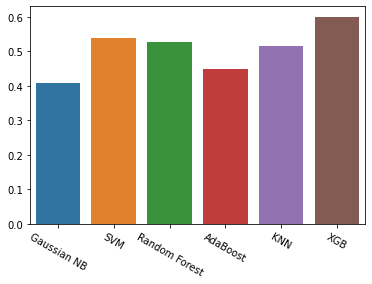

In [60]:
scores = [0.40893,0.53679,0.52607,0.44821,0.51536,0.6]
models = ["Gaussian NB","SVM","Random Forest","AdaBoost","KNN","XGB"]
sns.set_color_codes("muted")
acc_plot = sns.barplot(x=models, y=scores)
acc_plot.set_xticklabels(acc_plot.get_xticklabels(),rotation=-30)

In [61]:
#@title HIT PREDICTION
track_ids = tracks.index.tolist()
data_track = tracks.loc[track_ids]
feature_ids = features.index.tolist()
data_features = features.loc[feature_ids]

In [62]:
data_track

album                                                     \
         comments         date_created        date_released engineer   
track_id                                                               
2               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
3               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
5               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
10              0  2008-11-26 01:45:08  2008-02-06 00:00:00      NaN   
20              0  2008-11-26 01:45:05  2009-01-06 00:00:00      NaN   
...           ...                  ...                  ...      ...   
155316          0  2017-03-30 15:20:35  2017-02-17 00:00:00      NaN   
155317          0  2017-03-30 15:20:35  2017-02-17 00:00:00      NaN   
155318          0  2017-03-30 15:20:35  2017-02-17 00:00:00      NaN   
155319          0  2017-03-30 15:20:35  2017-02-17 00:00:00      NaN   
155320          0  2017-03-26 16:22:18  2017-03-26 00:00:00      NaN   

                                                                              \
         favorites     id                                        information   
track_id                                                                       
2                4      1                                            <p></p>   
3                4      1                                            <p></p>   
5                4      1                                            <p></p>   
10               4      6                                                NaN   
20               2      4          <p> "spiritual songs" from Nicky Cook</p>   
...            ...    ...                                                ...   
155316           0  22940  <p>A live performance at Monty Hall on Feb 17,...   
155317           0  22940  <p>A live performance at Monty Hall on Feb 17,...   
155318           0  22940  <p>A live performance at Monty Hall on Feb 17,...   
155319           0  22940  <p>A live performance at Monty Hall on Feb 17,...   
155320           1  22906                                                NaN   

                               \
         listens     producer   
track_id                        
2           6073          NaN   
3           6073          NaN   
5           6073          NaN   
10         47632          NaN   
20          2710          NaN   
...          ...          ...   
155316      1506  Monty Hall    
155317      1506  Monty Hall    
155318      1506  Monty Hall    
155319      1506  Monty Hall    
155320      7481          NaN   

                                                             ...       track  \
                                                       tags  ... information   
track_id                                                     ...               
2                                                        []  ...         NaN   
3                                                        []  ...         NaN   
5                                                        []  ...         NaN   
10                                                       []  ...         NaN   
20                                                       []  ...         NaN   
...                                                     ...  ...         ...   
155316                                                   []  ...         NaN   
155317                                                   []  ...         NaN   
155318                                                   []  ...         NaN   
155319                                                   []  ...         NaN   
155320    ['ballad', 'epic', 'rockabilly', 'curse', 'hex...  ...         NaN   

                                 \
         interest language_code   
track_id                          
2            4656            en   
3            1470            en   
5            1933            en   
10          54881            en   
20            978            en   
...           ... 

In [63]:
hitlist = pd.concat([tracks['track'][['listens']], features['mfcc']], axis=1)
labels = tracks['track']['genre_top']
hitlist_temp = pd.concat([tracks['track'][['genre_top','listens']], features['mfcc']], axis=1)


In [64]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import plot_tree, plot_importance

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_roc_curve

In [65]:
#@title Assessment of Models using AUC-ROC and Confusion matrix
def model_assess(model,title,X,Y):
    X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=42)

    model.fit(X_train,y_train)
    preds=model.predict(X_test)
    cm = confusion_matrix(y_test, preds, normalize='all')
    cmd = ConfusionMatrixDisplay(cm, display_labels=['No','Yes'])
    print('Accuracy', title, ':', round(accuracy_score(y_test, preds), 5), '\n')
    cmd.plot()
    plot_roc_curve(model, X_test, y_test)
    plt.show()

Rock
Accuracy Naive Bayes : 0.57015 



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



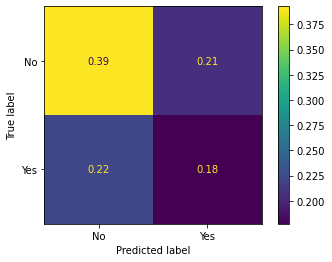

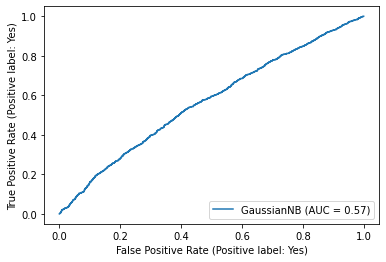

Rock
Accuracy KNN : 0.62726 



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



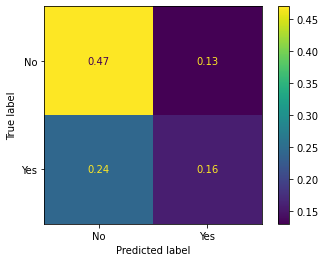

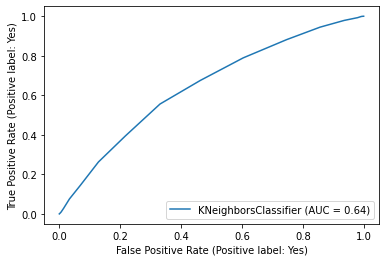

Rock
Accuracy Decision trees : 0.54078 



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



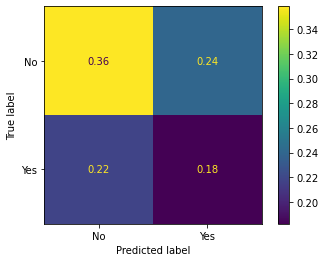

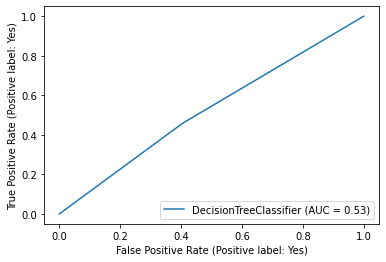

Rock
Accuracy Random Forest : 0.62092 



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



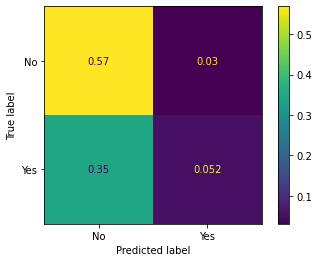

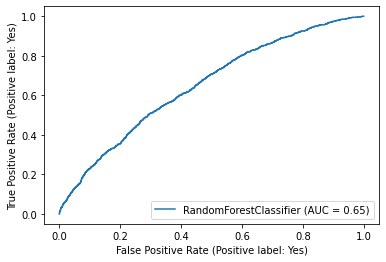

Rock
Accuracy Support Vector Machine : 0.59976 



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



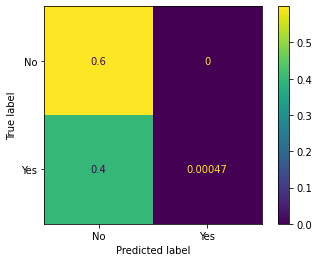

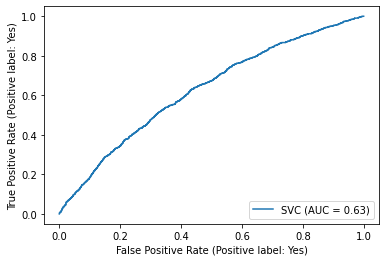

Rock


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



Accuracy Logistic Regression : 0.61081 



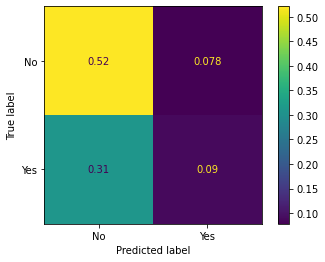

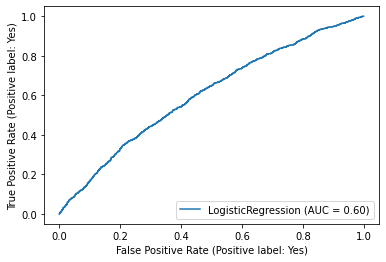

Experimental
Accuracy Naive Bayes : 0.54665 



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



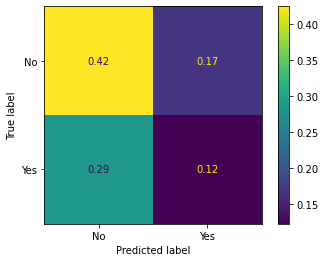

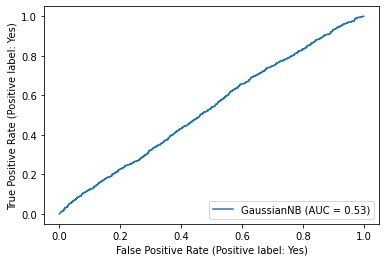

Experimental
Accuracy KNN : 0.59032 



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



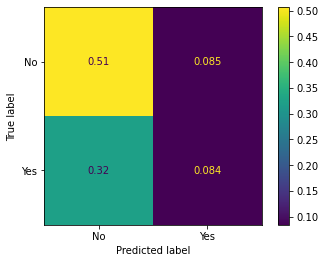

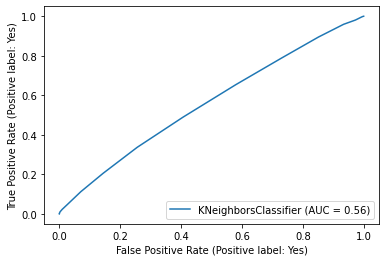

Experimental
Accuracy Decision trees : 0.51869 



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



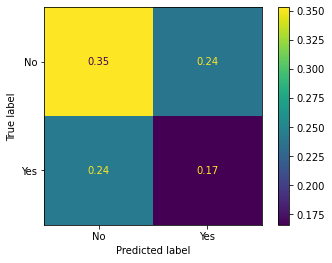

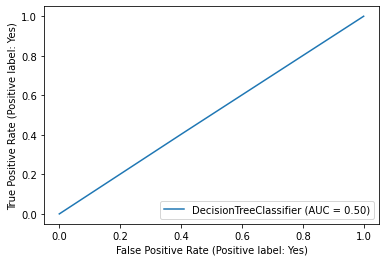

Experimental
Accuracy Random Forest : 0.59598 



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



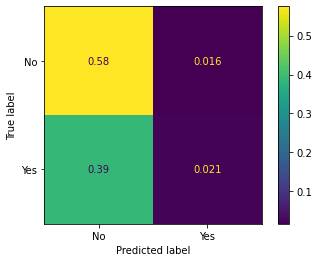

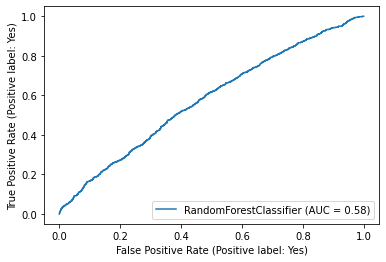

Experimental
Accuracy Support Vector Machine : 0.59158 



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



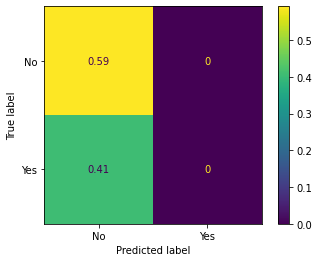

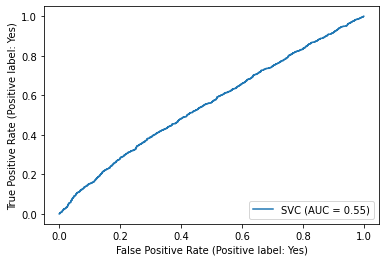

Experimental


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



Accuracy Logistic Regression : 0.58781 



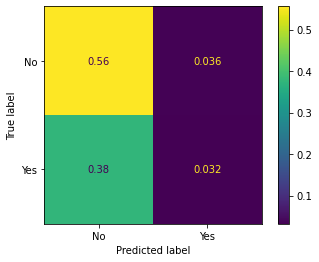

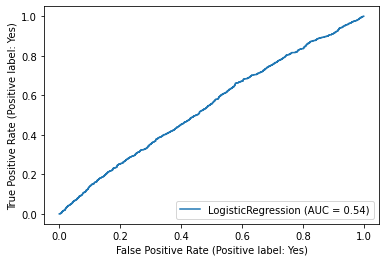

Electronic
Accuracy Naive Bayes : 0.51849 



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



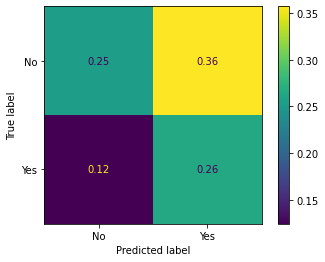

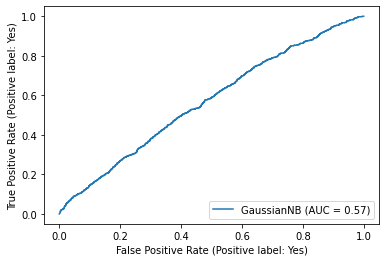

Electronic
Accuracy KNN : 0.59139 



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



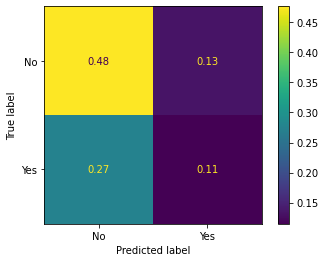

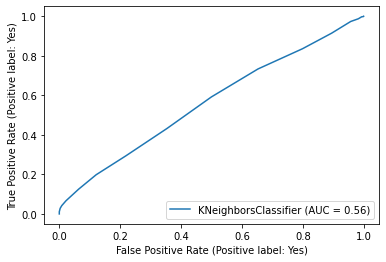

Electronic
Accuracy Decision trees : 0.5473 



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



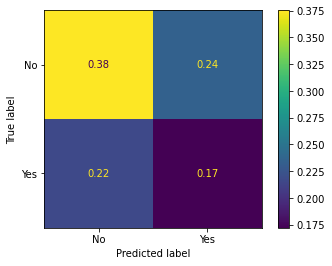

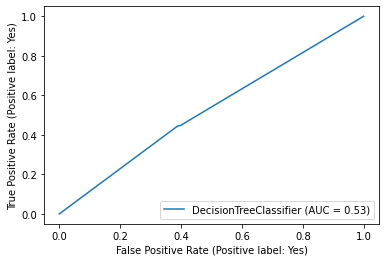

Electronic
Accuracy Random Forest : 0.62696 



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



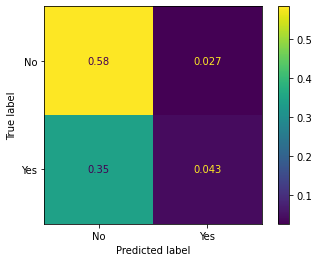

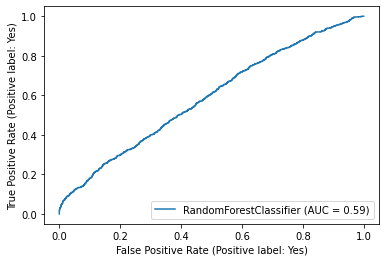

Electronic
Accuracy Support Vector Machine : 0.6266 



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



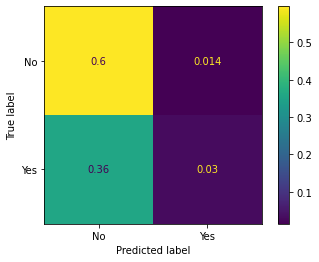

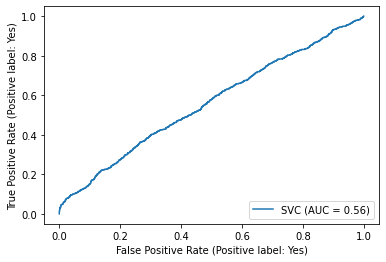

Electronic


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



Accuracy Logistic Regression : 0.60882 



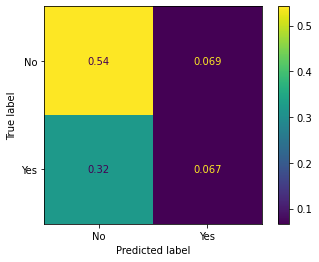

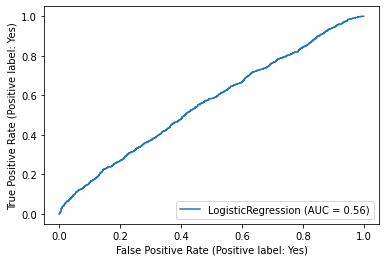

Hip-Hop
Accuracy Naive Bayes : 0.59099 



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



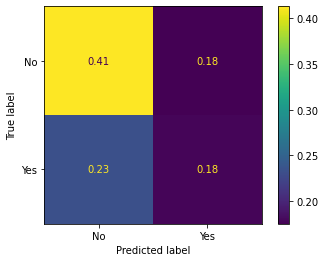

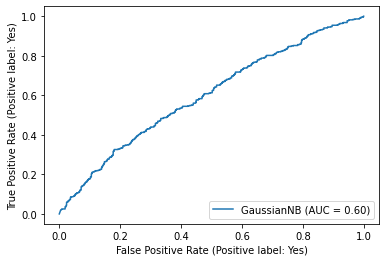

Hip-Hop
Accuracy KNN : 0.606 



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



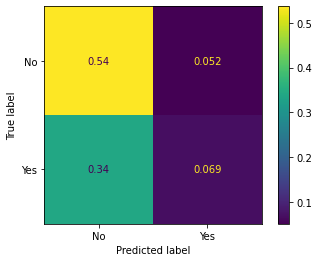

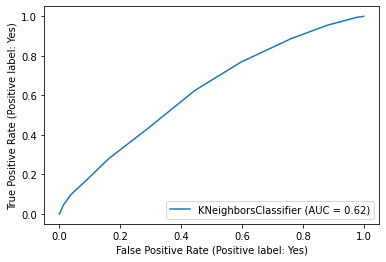

Hip-Hop
Accuracy Decision trees : 0.55441 



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



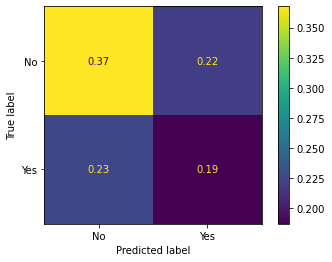

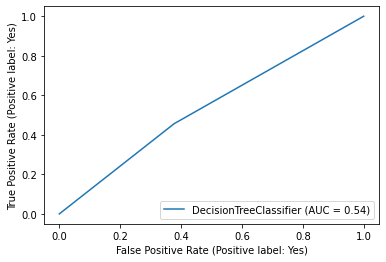

Hip-Hop
Accuracy Random Forest : 0.62946 



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



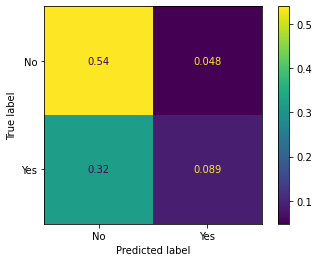

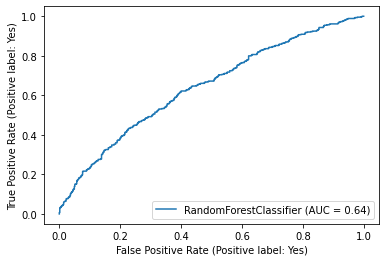

Hip-Hop
Accuracy Support Vector Machine : 0.59944 



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



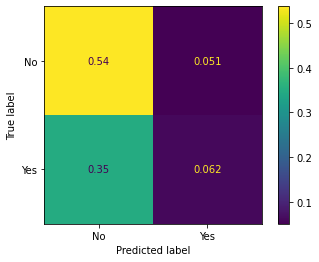

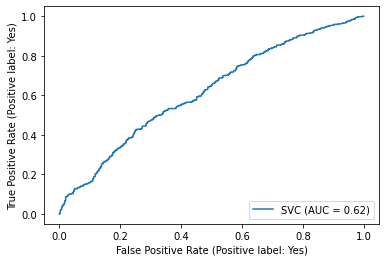

Hip-Hop
Accuracy Logistic Regression : 0.59662 



/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



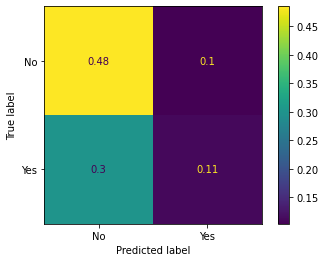

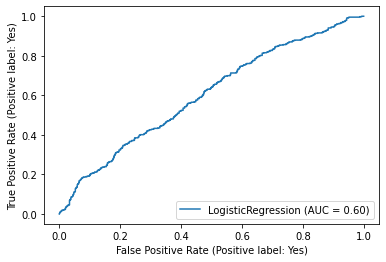

Folk
Accuracy Naive Bayes : 0.56956 



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



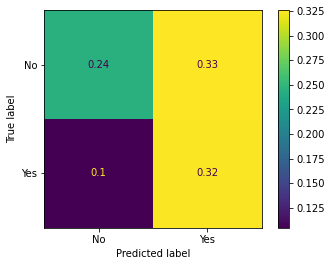

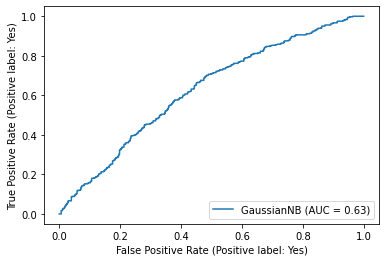

Folk
Accuracy KNN : 0.58977 



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



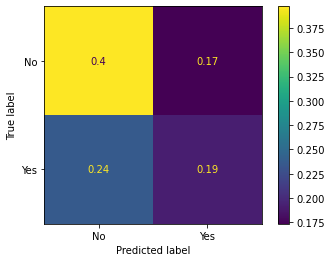

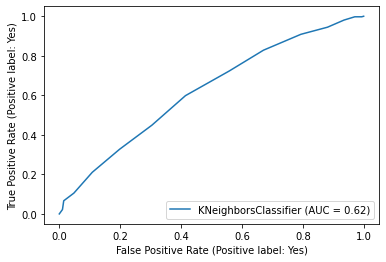

Folk
Accuracy Decision trees : 0.51605 



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



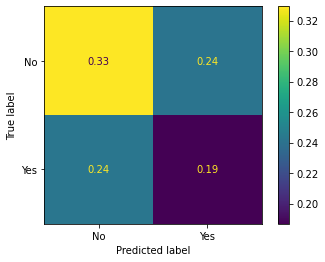

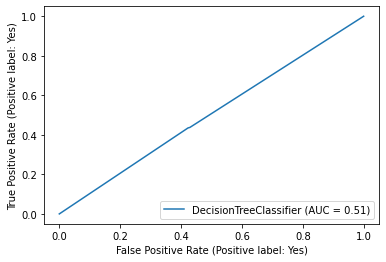

Folk
Accuracy Random Forest : 0.60999 



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



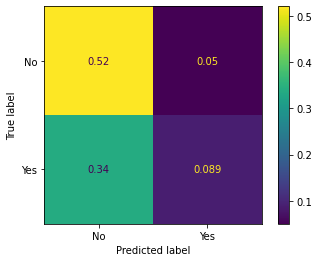

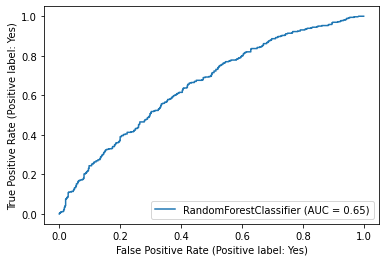

Folk
Accuracy Support Vector Machine : 0.60999 



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



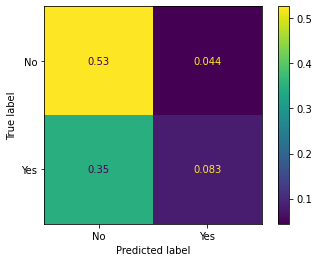

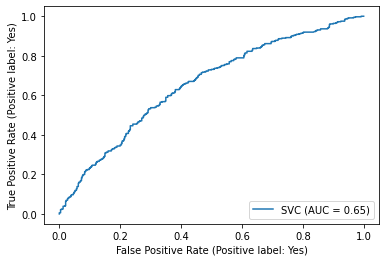

Folk
Accuracy Logistic Regression : 0.59215 



/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



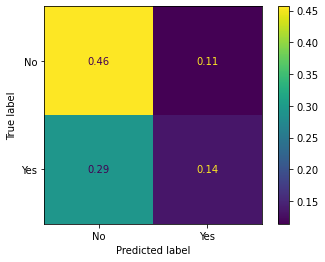

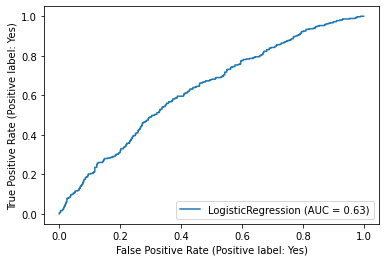

Pop
Accuracy Naive Bayes : 0.50143 



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



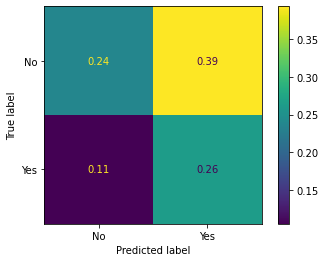

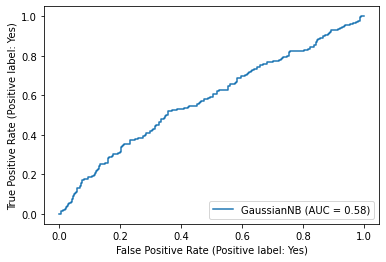

Pop
Accuracy KNN : 0.58429 



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



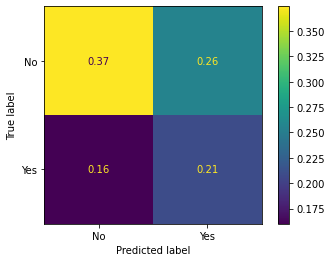

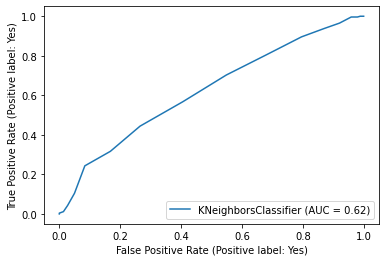

Pop
Accuracy Decision trees : 0.55429 



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



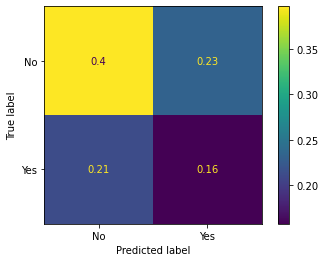

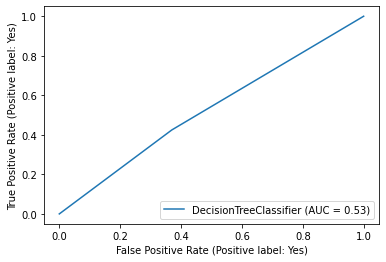

Pop
Accuracy Random Forest : 0.66286 



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



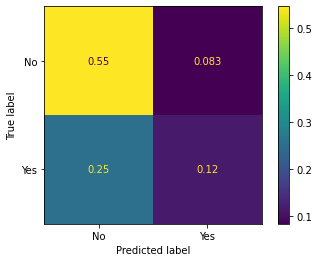

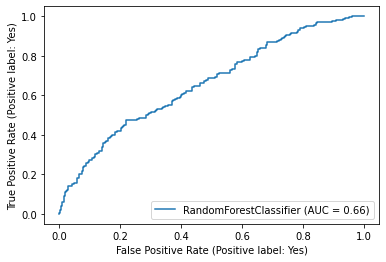

Pop
Accuracy Support Vector Machine : 0.63571 



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



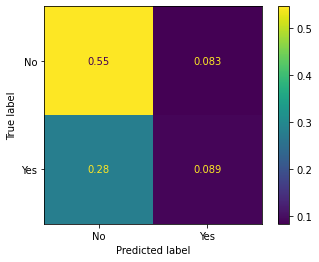

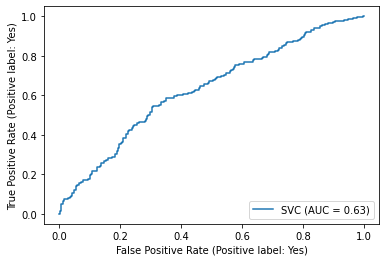

Pop
Accuracy Logistic Regression : 0.62571 



/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



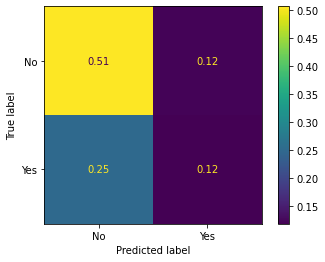

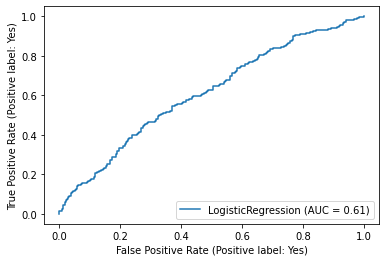

Instrumental
Accuracy Naive Bayes : 0.55609 



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



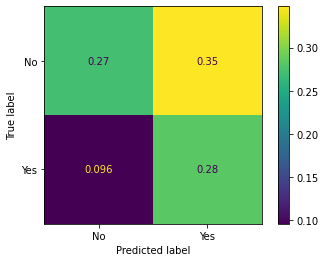

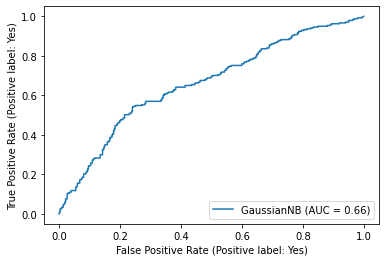

Instrumental
Accuracy KNN : 0.60897 



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



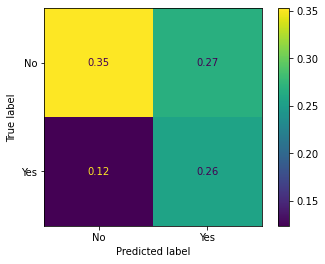

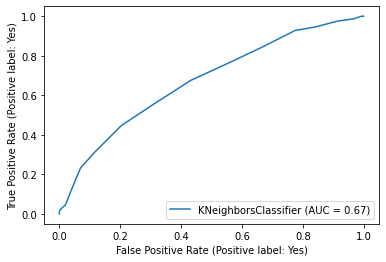

Instrumental
Accuracy Decision trees : 0.59776 



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



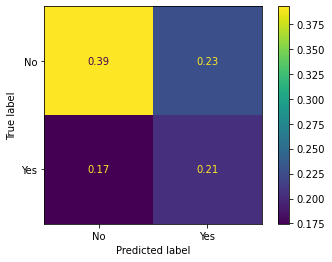

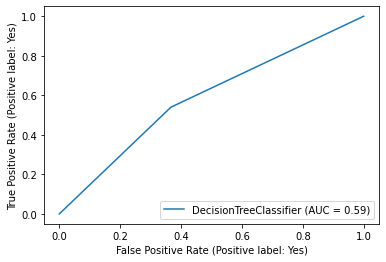

Instrumental
Accuracy Random Forest : 0.70833 



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



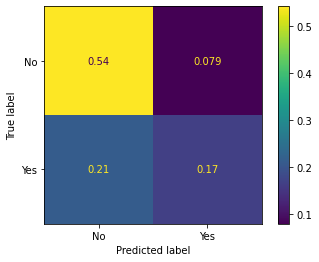

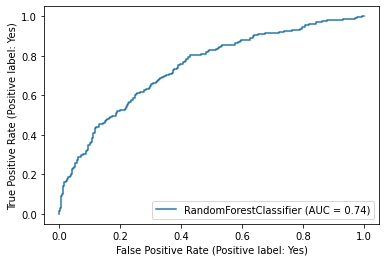

Instrumental
Accuracy Support Vector Machine : 0.6891 



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



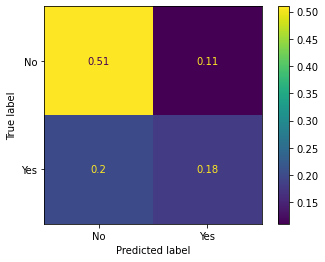

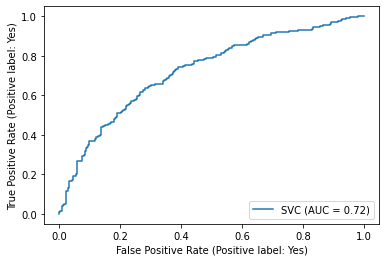

Instrumental
Accuracy Logistic Regression : 0.66346 



/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



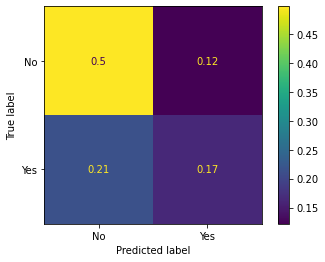

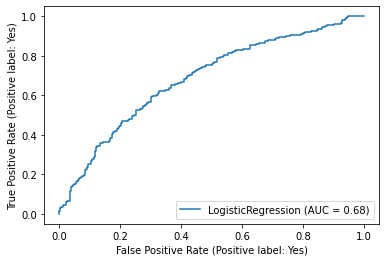

In [66]:
iter_data = ['rock_data', 'experimental_data', 'electronic_data', 'hip_Hop_data', 'folk_data', 'pop_data', 'instrumental_data']
iter = ['Rock', 'Experimental', 'Electronic', 'Hip-Hop', 'Folk', 'Pop', 'Instrumental']
hitlist_temp = hitlist_temp.groupby('genre_top')
for i in range(len(iter_data)):
  
  temp_df = pd.DataFrame(hitlist_temp.get_group(iter[i]))
  temp_df['listens'] = np.where(temp_df['listens'] >= temp_df['listens'].quantile(0.6), "Yes", "No")
  Y=temp_df.loc[:,'listens']

  X=temp_df.loc[:,temp_df.columns!='listens']
  X = X.drop(['genre_top'], axis=1)
  X.columns = [x[1] for x in X.columns]

  cols=X.columns

  scaler=preprocessing.MinMaxScaler()
  scaled_X=scaler.fit_transform(X)

  X=pd.DataFrame(scaled_X,columns=cols)

  # Naive Bayes
  print(iter[i])
  nb = GaussianNB()
  model_assess(nb, "Naive Bayes",X,Y)

  # KNN
  print(iter[i])
  knn = KNeighborsClassifier(n_neighbors=19)
  model_assess(knn, "KNN",X,Y)

  # Decision trees
  print(iter[i])
  tree = DecisionTreeClassifier()
  model_assess(tree, "Decision trees",X,Y)

  # Random Forest
  print(iter[i])
  rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
  model_assess(rforest, "Random Forest",X,Y)

  # Support Vector Machine
  print(iter[i])
  svm = SVC(decision_function_shape="ovo")
  model_assess(svm, "Support Vector Machine",X,Y)

  # Logistic Regression
  print(iter[i])
  lg = LogisticRegression()
  model_assess(lg, "Logistic Regression",X,Y)

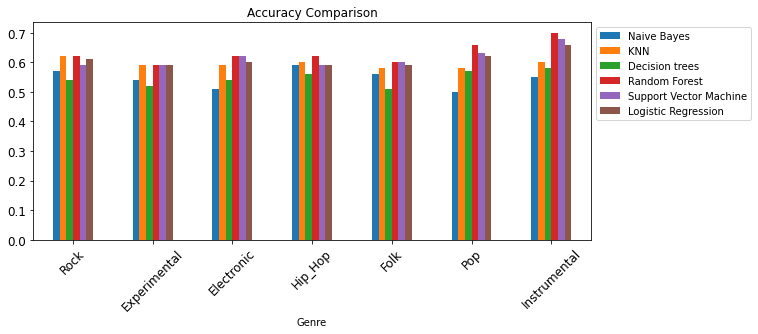

In [67]:
#@title Vizualization of Results
labels = ['Rock', 'Experimental', 'Electronic', 'Hip_Hop', 'Folk', 'Pop', 'Instrumental']
Rock = [0.57, 0.62, 0.54, 0.62, 0.59, 0.61]
Experimental = [0.54, 0.59, 0.52, 0.59, 0.59, 0.59, 0.58]
Electronic = [0.51, 0.59, 0.54, 0.62, 0.62, 0.60]
Hip_Hop = [0.59, 0.60, 0.56, 0.62, 0.59, 0.59]
Folk = [0.56, 0.58, 0.51, 0.60, 0.60, 0.59]
Pop = [0.50, 0.58, 0.57, 0.66, 0.63, 0.62]
Instrumental = [0.55, 0.60, 0.58, 0.70, 0.68, 0.66]

import matplotlib.pyplot as plt
import numpy as np
df = pd.DataFrame([['Rock', 0.57, 0.62, 0.54, 0.62, 0.59, 0.61], 
                   ['Experimental',0.54, 0.59, 0.52, 0.59, 0.59, 0.59], 
                   ['Electronic', 0.51, 0.59, 0.54, 0.62, 0.62, 0.60],
                   ['Hip_Hop', 0.59, 0.60, 0.56, 0.62, 0.59, 0.59],
                   ['Folk', 0.56, 0.58, 0.51, 0.60, 0.60, 0.59],
                   ['Pop', 0.50, 0.58, 0.57, 0.66, 0.63, 0.62],
                   ['Instrumental', 0.55, 0.60, 0.58, 0.70, 0.68, 0.66],
                  ],
                  columns=['Genre',"Naive Bayes", "KNN", "Decision trees", "Random Forest", "Support Vector Machine", "Logistic Regression"])

df.plot(x='Genre',kind='bar', stacked=False,title='Accuracy Comparison', figsize=(10,4), fontsize='large', rot=45)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()
